In [1]:
%matplotlib inline
import sys
sys.path.append("src") # add the source dir

In [2]:
from pipeline import Pipeline, MultiPipeline
from decoding_analysis import CVPipleline, LDADecoder, EEGDecoder, MNECSPTransformer
from preprocessing import CleaningData, SimpleMNEFilter, PrecomputedICA
from mne_bids import BIDSPath
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import logging

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold

from mne.decoding import Vectorizer, CSP

from sklearn import svm

# Decoding Analysis

### Decoding analysis on a single subject (subject 15)

In [4]:
# set the bids path
bids_root = os.path.join('data', 'P3');
bids_path = BIDSPath(subject='015', session='P3', task='P3',
                        datatype='eeg', suffix='eeg', root=bids_root);

In [5]:
# Initialize Pipeline and execute init actions
pipeline = Pipeline(bids_path, verbose=logging.ERROR);
pipeline.load_data();
pipeline.set_custom_events_mapping(task='P3');
pipeline.set_montage();
# perform the preprocessing steps
pipeline.make_pipeline([SimpleMNEFilter(0.1, 50, 'firwin'), CleaningData(bids_path), PrecomputedICA(bids_path)]);

We will initialize an object of `ERPAnalysis` which will have all the data regarding the ERP analysis, we will also run the pipeline till the processing step

In [6]:
# define our decoder
epochs_window = (-0.1, 0.8)
training_window = (0.0, 0.7) # we don't want to train before stimulus onset
stimulus = 'stimulus' # we don't want to train on reponses
decoder = EEGDecoder(stimulus, epochs_window, training_window, pipeline.raw, baseline=(None, 0), reject_by_annotation=True);

## Common spatial pattern (CSP)

CSP belongs to the class of Spartial filters, and provide weights to modify the data along the sensor space. They can seperate the multivariate signal into additive subcomponents which have maximum differences in variance between the two window functions

The MNE library has a bug (LinAlgError) on CSP calculations. FYI: the issue, [https://github.com/mne-tools/mne-python/issues/9094](https://github.com/mne-tools/mne-python/issues/9094)

Therefore, we decided not to use CSP tranformation on single subject epochs.

## Vectorizer

Vectorizer belongs to set of transformation classes which converts the MNE data which is in the form of $(n_samples * n_channels * n_frequencies * n_times)$ to more generalized $(n_samples * n_features)$ form. In the process MNE uses all sensors and time points as seperate classification features, Hence, the result filter is also called **spartio-temporal**

After applying vectorizer, we can use output with any other Machine learning algorithm.

## Scoring (Evaluation metrics)

For measuring the performace of our algorithms, we use

`auc_roc`

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability.[1]

`f1-scores`

The F1 Score is the $2* \frac{ precision * recall }{ precision + recall}$. It is also called the F Score or the F Measure. Put another way, the F1 score conveys the balance between the precision and the recall[2]. Accuracy scores can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes.

Reference

[1] [https://en.wikipedia.org/wiki/Receiver_operating_characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

[2] [http://mlwiki.org/index.php/Precision_and_Recall](http://mlwiki.org/index.php/Precision_and_Recall)

## CrossValidation and Extension (using Sklearn Pipeline)

As discussed, the purpose of using Vectorizer is to convert EEG data from (n_epochs, n_channels, n_times) structure to a vector of (samples, channels) form. Additionally, we will use `StandardScaler()` to remove the mean and scale to unit variance.

**StandardScaler** standardizes our data feature-wise by the formulation of $z = \frac{(x - u)}{s}$. In this formula, `u` is the mean of the feature and `s` is the standard deviation of the same feature. By applying this technique, each feature's mean and standard deviation will become zero and one respectively. Standardization of features, which are eeg channels in our case prevent domination of a channel(or a feature) just becuase it contains larger variation.


## Classifiers

### Support Vector Machine (SVM)

The SVM algorithm is used to find a hyperplane in an N-dimentional space that distinctly classifies the data points. The hyperplan objective is to maximize the distance (also know as margin) between the data points of different classes.

Support vectors are the datapoints which are closer to the hyperplan and influence its position and orientation.

Regularization coefficient C:

In Sklearn implementation, C is 1 by default. If we have a lot of noisy observations we should consider decreasing it. Therefore, decreasing C corresponds to more regularization.

Kernels:

To transform and seperate the classes, kernel function are used. They can transform the data points from a higher dimension to a lower dimension. In our project, we use `linear, rbf, and sigmoid` kernels. 


In [7]:
# we use only two channels which are located in the central region of brain,
# where we expect the brain activity to be highest for our P3 task.
data, labels = decoder.get_train(channels=['Cz', 'CPz']) # get training data

# define our pipeline, we use SVM classifier with linear kernel and C=1
clf_svm = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='linear', C=1, random_state=42))
scores = cross_val_score(clf_svm, data, labels, cv=5, scoring='roc_auc');

for i in range(len(scores)):
    print('Accuracy of ' + str(i+1) + 'th fold is ' + str(scores[i]));
print('Mean accuracy {}'.format(np.mean(scores)));

Accuracy of 1th fold is 0.49609375
Accuracy of 2th fold is 0.671875
Accuracy of 3th fold is 0.734375
Accuracy of 4th fold is 0.7857142857142858
Accuracy of 5th fold is 0.6169354838709677
Mean accuracy 0.6609987039170507


## Hyperparameter Optimization

SVM performs better than random chance, however we are usign fixed parameters. Often, it is not easy to decide the best parameters for our model. Hence, we use the hyperparameter optimization technique to find out the best kernels and constant value

We use GridSearchCV which searches the best performing parameters among the given list of possible parameter values exhaustedly. Additionally we specify the scoring method as `roc_auc` and cross validation strategy as `StratifiedKFold` inside GridSearchCV. We use `StratifiedKFold` strategy becuse this strategy divides data into folds with approxiamtely same percentage of classes as the whole dataset.


In [8]:
#svm
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42));
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C': [0.01, 0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='roc_auc', cv=StratifiedKFold(n_splits=5), return_train_score=True, n_jobs=4);

In [9]:
data, labels = decoder.get_train();
gs_cv_svm.fit(data, labels)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_));
print('Best Score: {}'.format(gs_cv_svm.best_score_));

Best Parameters: {'svc__C': 0.01, 'svc__kernel': 'sigmoid'}
Best Score: 0.8489127304147465


### Note: While the algorithm is trained on unbalanced number samples for each class (rare, freq), we do not fix this here, because doing this for one subject significantly reduces the number of samples to a point where using any machine learning techniques is pointless

<AxesSubplot:>

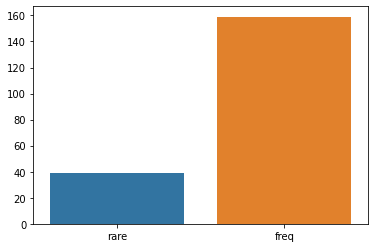

In [10]:
#As we can see if we try to equalize the number of samples for each class, we would have total of 50 samples.
sns.barplot(x=['rare', 'freq'], y=[len(np.where(labels == 1)[0]), len(np.where(labels == 2)[0])])

Also, this might we the reason for low score of our SVM algorithm, we simply do not have more rare sample points on which our algorithm can be trained.

## Classification Over time (for a single subject, we will later do further analysis)

We use the `SlidingEstimator` class by MNE to fit a linear model for each time point in our training window.
Based on the score, we can identify the time periods for which our model performs best

In [11]:
tsr = decoder.run_sliding_()

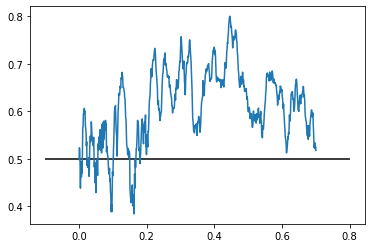

In [12]:
# We observe good scores between the time period 200ms to 600ms, which is the significant time window for our P3 class
plt.plot(tsr[0],tsr[1].mean(axis=0));
plt.hlines(0.5,-0.1,0.8,'k');

# Analysing spatio-temporal classification scores of all subjects

To circumvent the problem of unbalanced number of samples in the classes,

 - we loaded all the subject data in one raw object using `raw.concatenate` function provided by MNE
 - We resampled the data, and equalized the number of rare and frequent events
 - After, we ran our best classifer to measure the performance again

The function `mne.epochs.equalize_events_count()` can equalize the events in the epochs based on the condition. However, it is not very flexible - in terms of hierarchy (stimulus and condition), Hence, we use our own function to equalize the number of samples based on number of classes

In [13]:
pipeline.load_multiple_subjects(40, preload=True); #finds the other subjects from the bids path excluding the current subject
pipeline.apply_resampling(256);

100%|██████████| 39/39 [00:37<00:00,  1.03it/s]


In [14]:
# define a new decoder, we use the the training window form 100ms, 700ms 
decoder = EEGDecoder('stimulus', (-0.1, 1), (0.1, 0.7), pipeline.raw, baseline=(None, 0), reject_by_annotation=True, reject=dict(eeg=250e-6));

In [15]:
# we use the `CSP` to transform the data
csp_data, labels = decoder.feature_transform(MNECSPTransformer(6));
# plotting this is not very helpful

In [16]:
# simple LDA decoder to treat ourselves
lda = LDADecoder();
lda.fit(csp_data, labels);
print('Accuracy of LDA classifier {}'.format(lda.predict(csp_data, labels)));

Accuracy of LDA classifier 0.8002564102564103


<AxesSubplot:>

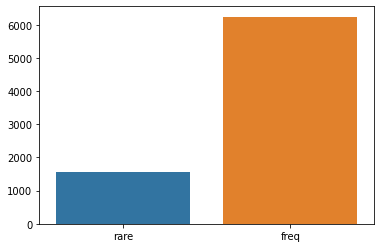

In [17]:
# checking number of samples in each class
sns.barplot(x=['rare', 'freq'], y=[len(np.where(labels == 1)[0]), len(np.where(labels == 2)[0])])

## Equilizing the unbalanced classes

we use `equalize_labels_count` to equalize the number of samples in each class [rare, freq] and train on channels in the central and perital regions of the brain

In [18]:
data, labels = decoder.get_train(channels=['Pz', 'CPz', 'Cz'], equalize_labels_count=True);

<AxesSubplot:>

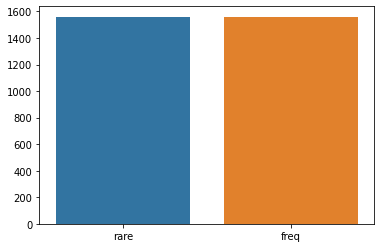

In [19]:
sns.barplot(x=['rare', 'freq'], y=[len(np.where(labels == 1)[0]), len(np.where(labels == 2)[0])])

In [20]:
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='roc_auc', cv=StratifiedKFold(5, True, 114), n_jobs=6, return_train_score=True);
gs_cv_svm.fit(data, labels)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_));
print('Best Score: {}'.format(gs_cv_svm.best_score_));

Best Parameters: {'svc__C': 10, 'svc__kernel': 'rbf'}
Best Score: 0.6658366206443129


As expected, equlizing training samples, decreased the Accuracy!

In [21]:
stim_data = decoder.get_all_stim()
train_a, labels_a = stim_data['A']['norm_samples'][0], stim_data['A']['norm_samples'][1]
train_b, labels_b = stim_data['B']['norm_samples'][0], stim_data['B']['norm_samples'][1]
train_c, labels_c = stim_data['C']['norm_samples'][0], stim_data['C']['norm_samples'][1]
train_d, labels_d = stim_data['D']['norm_samples'][0], stim_data['D']['norm_samples'][1]
train_e, labels_e = stim_data['E']['norm_samples'][0], stim_data['E']['norm_samples'][1]

In [22]:

# run SVM on all stimulus
all_scores= []
clf_svm = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='rbf', C=1, random_state=42))
scores = cross_val_score(clf_svm, train_a, labels_a, cv=5, scoring='roc_auc');
all_scores.append(scores)
scores = cross_val_score(clf_svm, train_b, labels_b, cv=5, scoring='roc_auc');
all_scores.append(scores)
scores = cross_val_score(clf_svm, train_c, labels_c, cv=5, scoring='roc_auc');
all_scores.append(scores)
scores = cross_val_score(clf_svm, train_d, labels_d, cv=5, scoring='roc_auc');
all_scores.append(scores)
scores = cross_val_score(clf_svm, train_e, labels_e, cv=5, scoring='roc_auc');
all_scores.append(scores)

<AxesSubplot:>

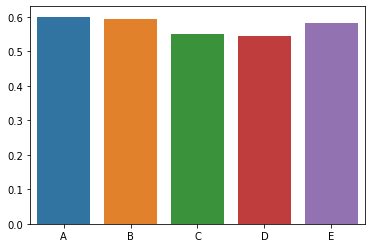

In [23]:
sns.barplot(x=['A', 'B', 'C', 'D', 'E'], y=np.array(all_scores).mean(axis=1))

# Classification Over time for all the subjects

In [24]:
pipelines = MultiPipeline(bids_root)
pipelines = pipelines.start_preprocessing()

100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


### We trained the classifier on two decoders

- Decoder 1:

  - epoch times: (-0.1, 0.8)
  - training time: (0.0, 0.7)
  - Equalized number of rare and freq events

- Decoder 2:

  - epoch times: (-0.1, 0.8)
  - training time: (0.0, 0.7)
  - unbalanced number of rare and freq events

In [25]:
from tqdm import tqdm
subs = { 'id': [], 'times' : [], 'scores': [], 'uneq_times' : [], 'uneq_scores': []  } 
for i, pipeline in enumerate(tqdm(pipelines)):
    decoder = EEGDecoder('stimulus', (-0.1, 0.8), (0.0, 0.7), pipeline.raw, equalize_events=True, equalize_ids=['rare', 'freq'])
    times, scores = decoder.run_sliding_()
    subs['times'].append(times)
    subs['scores'].append(scores)
    subs['id'].append(i)
    eq_decoder = EEGDecoder('stimulus', (-0.1, 0.8), (0.0, 0.7), pipeline.raw)
    uneq_times, uneq_scores = eq_decoder.run_sliding_()
    subs['uneq_times'].append(uneq_times)
    subs['uneq_scores'].append(uneq_scores)

100%|██████████| 40/40 [01:42<00:00,  2.55s/it]


In [26]:
import pandas as pd
df = pd.DataFrame.from_dict(subs)

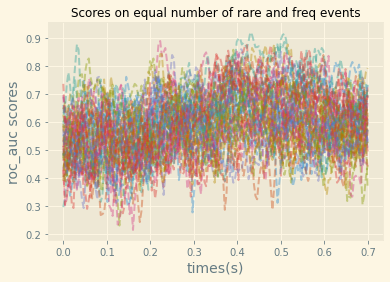

In [27]:
snsdict = {'i':[], 'x':[], 'y' :[], 'x_': [], 'y_':[]}
# use new theme plot
with plt.style.context('Solarize_Light2'):
    for i in range(1, 41):
        id_ = np.ones(df.iloc[i-1].times.shape[0])
        id_.fill(i-1)
        snsdict['i'].extend(id_)
        snsdict['x'].extend(df.iloc[i-1].times.flatten())
        snsdict['x_'].extend(df.iloc[i-1].uneq_times.flatten())
        snsdict['y'].extend(df.iloc[i-1].scores.mean(axis=0).flatten())
        snsdict['y_'].extend(df.iloc[i-1].uneq_scores.mean(axis=0).flatten())
        plt.plot(df.iloc[i-1].times, df.iloc[i-1].scores.mean(axis=0), label='sub {}'.format(i), scalex=True, ls='--', alpha=0.4);
# plot the scores
plt.title('Scores on equal number of rare and freq events')
plt.ylabel('roc_auc scores', fontsize=14)
plt.xlabel('times(s)', fontsize=14)
plt.show()

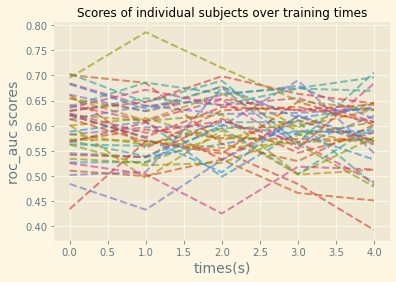

In [28]:
with plt.style.context('Solarize_Light2'):
    for i in range(1, 41):
        plt.plot(df.iloc[i-1].scores.mean(axis=1), label='sub {}'.format(i), scalex=True, ls='--', alpha=0.6);
plt.title('Scores of individual subjects over training times')
plt.ylabel('roc_auc scores', fontsize=14)
plt.xlabel('times(s)', fontsize=14)
plt.show()

In [29]:
# construct a dataframe for sns plotting
ds = pd.DataFrame.from_dict(snsdict)

## Plot average scores for all the subjects

Text(0.5, 0, 'times(s)')

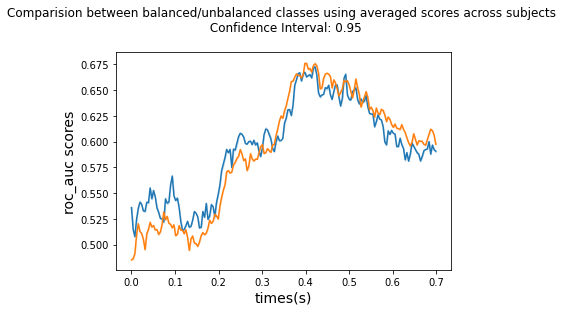

In [30]:
# balanced classes
ax = sns.lineplot(data=ds, x='x', y='y', ci=0.95)
# unbalanced classes
ax = sns.lineplot(data=ds, x='x_', y='y_', ci=0.95)

ax.set_title('Comparision between balanced/unbalanced classes using averaged scores across subjects \n Confidence Interval: 0.95\n')
ax.set_ylabel('roc_auc scores', fontsize=14)
ax.set_xlabel('times(s)', fontsize=14)

Text(0.5, 0, 'times(s)')

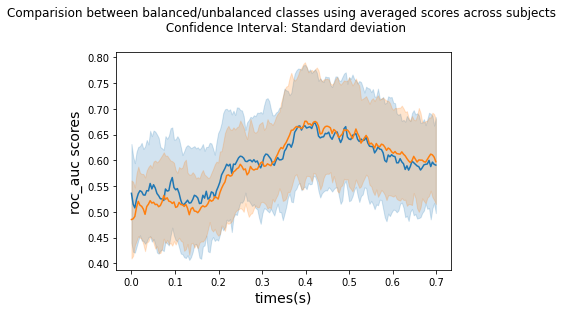

In [31]:
ax = sns.lineplot(data=ds, x='x', y='y', ci='sd')
ax = sns.lineplot(data=ds, x='x_', y='y_', ci='sd')

ax.set_title('Comparision between balanced/unbalanced classes using averaged scores across subjects \n Confidence Interval: Standard deviation\n')
ax.set_ylabel('roc_auc scores', fontsize=14)
ax.set_xlabel('times(s)', fontsize=14)

Although, we do not achieve good classification scores but our models show that we have achieved relatively good scores to make a comparision between the classification score around time window between 300ms to 600ms.

Hence, we conclude that using time from window of 200ms-600ms, the `rare` or `target` can be easily classified from `freq` or `distractor` events.